In [3]:
! pip install pandas
! pip install numpy
! pip install python-docx


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/244.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/244.3 kB ? eta -:--:--
   - -------------------------------------- 10.2/244.3 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/244.3 kB 262.6 kB/s eta 0:00:01
   --------- ----------------------------- 61.4/244.3 kB 409.6 kB/s eta 0:00:01
   ------------------- ------------------ 122.9/244.3 kB 654.9 kB/s eta 0:00:01
   ---------------------------------------- 244.3/244.3 kB 1.1 MB/s eta 0:00:00


In [32]:
! pip install cross_encoder

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement cross_encoder (from versions: none)
ERROR: No matching distribution found for cross_encoder


Загружено 34 уникальных навыков


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\neuty\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


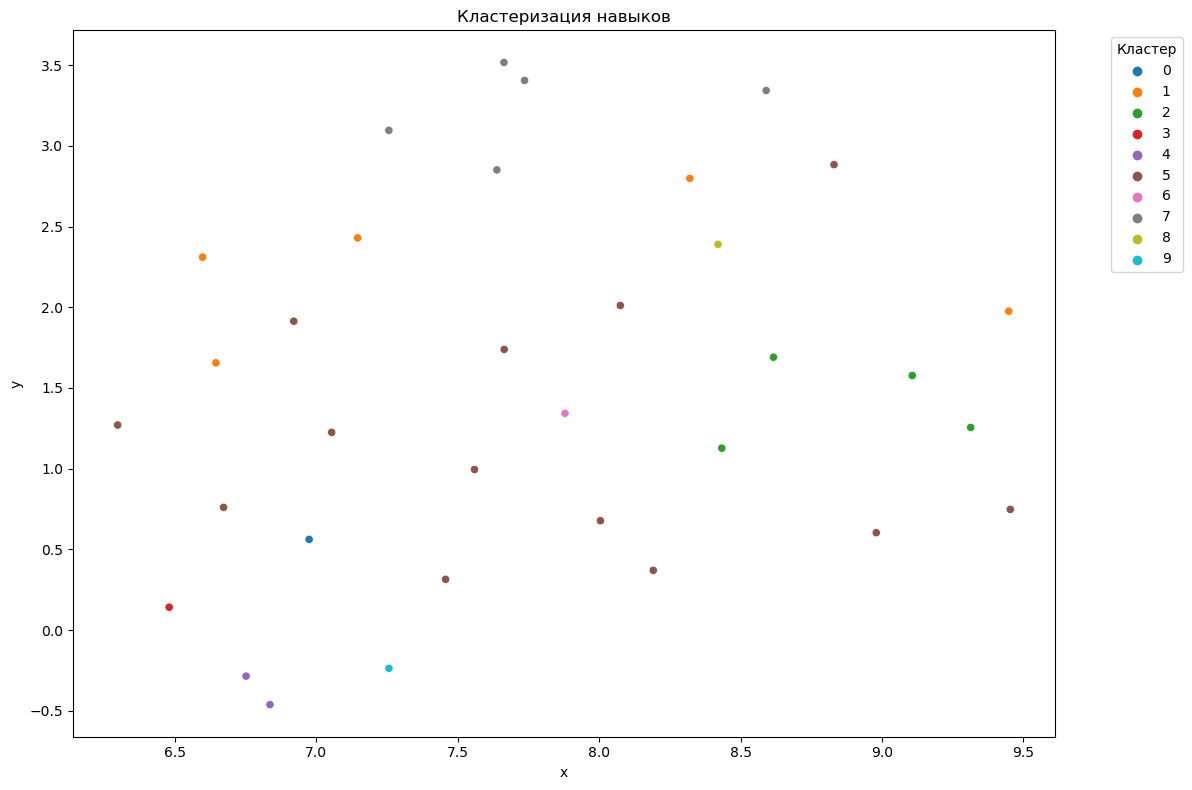

FileNotFoundError: [Errno 2] No such file or directory: 'data/sample_resume.txt'

In [ ]:
import os
os.makedirs('models', exist_ok=True)


import pandas as pd
import numpy as np
import re

# Monkey patch for OpenBLAS bug in threadpoolctl (temporary fix)
import threadpoolctl
threadpoolctl._ThreadpoolInfo._load_modules = lambda self: setattr(self, 'modules', [])

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
# === Убедитесь, что установлены необходимые зависимости ===
# pip install sentence-transformers
# pip install setuptools wheel
# pip install spacy

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

# Импорт с проверкой наличия библиотеки UMAP
try:
    import umap
except ImportError:
    raise ImportError("UMAP не установлен. Установите пакет с помощью: pip install umap-learn")

# Импорт с проверкой наличия spaCy
try:
    import spacy
except ImportError:
    raise ImportError("spaCy не установлен. Установите пакет с помощью: pip install spacy")

# === NLP-модель для NER и нормализации ===
try:
    import spacy
    try:
        nlp = spacy.load("en_core_web_sm")
    except OSError:
        from spacy.cli import download
        download("en_core_web_sm")
        nlp = spacy.load("en_core_web_sm")
except ImportError:
    raise ImportError("spaCy не установлен. Установите с помощью: pip install spacy")

from sentence_transformers import SentenceTransformer, CrossEncoder

# === Конфигурация ===
MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'
CROSS_ENCODER_MODEL = 'cross-encoder/stsb-TinyBERT-L-4'
N_CLUSTERS = 10
RANDOM_STATE = 42

# === NLP-модель для NER и нормализации ===
nlp = spacy.load("en_core_web_sm")

# === 1. Загрузка и подготовка данных из alliance_matrix.json ===
def load_skills_from_alliance(json_path: str) -> pd.DataFrame:
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    all_skills = []
    for role_id, role_data in data["roles"].items():
        for comp in role_data["competencies"]:
            skill_name = comp["name"].strip().lower()
            all_skills.append({
                "role": role_id,
                "group": comp["group"],
                "name": skill_name,
                "level_code": comp.get("required_level_code"),
                "level_name": comp.get("required_level_name")
            })

    df = pd.DataFrame(all_skills).drop_duplicates(subset=["name"])
    return df

# === 2. Векторизация навыков ===
def embed_skills(skills: pd.Series, model_name=MODEL_NAME) -> np.ndarray:
    model = SentenceTransformer(model_name)
    embeddings = model.encode(skills.tolist(), show_progress_bar=True)
    return embeddings

# === 3. Кластеризация навыков ===
def cluster_skills(embeddings: np.ndarray, n_clusters=N_CLUSTERS) -> np.ndarray:
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, batch_size=64)
    cluster_labels = kmeans.fit_predict(embeddings)

    return cluster_labels, kmeans

# === 4. Визуализация с понижением размерности ===
def visualize_clusters(embeddings: np.ndarray, labels: np.ndarray, skills: pd.Series):
    reducer = umap.UMAP(random_state=RANDOM_STATE)
    reduced = reducer.fit_transform(embeddings)
    df_vis = pd.DataFrame({
        'x': reduced[:, 0],
        'y': reduced[:, 1],
        'cluster': labels,
        'skill': skills
    })
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df_vis, x='x', y='y', hue='cluster', palette='tab10')
    plt.title('Кластеризация навыков')
    plt.legend(title='Кластер', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# === 5. Информационное извлечение из резюме ===
def extract_resume_skills(resume_text: str) -> list:
    doc = nlp(resume_text)
    skills = [ent.text.lower() for ent in doc.ents if ent.label_ in ['ORG', 'PRODUCT', 'SKILL']]
    return list(set(skills))

# === 6. Нормализация навыков ===
def normalize_skills(skills: list, synonyms_dict: dict) -> list:
    normalized = []
    for skill in skills:
        for norm, variants in synonyms_dict.items():
            if skill in variants:
                normalized.append(norm)
                break
        else:
            normalized.append(skill)
    return list(set(normalized))

# === 7. Семантическое сопоставление компетенций ===
def match_skills(candidate_skills: list, job_requirements: list) -> pd.DataFrame:
    model = CrossEncoder(CROSS_ENCODER_MODEL)
    pairs = [(c, j) for c in candidate_skills for j in job_requirements]
    scores = model.predict(pairs)
    df = pd.DataFrame(pairs, columns=['candidate_skill', 'job_requirement'])
    df['score'] = scores
    matched = df[df['score'] > 0.7]  # эмпирический порог
    return matched.sort_values(by='score', ascending=False)

# === 8. Оценка важности навыков в вакансии ===
def assess_skill_importance(job_description: str, skill_list: list) -> dict:
    importance = {}
    job_text = job_description.lower()
    for skill in skill_list:
        count = len(re.findall(r'\b' + re.escape(skill.lower()) + r'\b', job_text))
        if count >= 2:
            importance[skill] = 'high'
        elif count == 1:
            importance[skill] = 'medium'
        else:
            importance[skill] = 'low'
    return importance

# === 9. Основной пайплайн ===
def main():
    # --- Кластеризация навыков ---
    skill_file_path = 'data/skills.csv'  # Файл должен содержать колонку 'skill'
    df_skills = load_skills_from_alliance('data/alliance_matrix.json')
    print(f"Загружено {len(df_skills)} уникальных навыков")

    embeddings = embed_skills(df_skills['name'])
    labels, kmeans_model = cluster_skills(embeddings)

    df_skills['cluster'] = labels
    df_skills.to_csv('data/clustered_skills.csv', index=False)

    joblib.dump(kmeans_model, 'models/skill_kmeans.pkl')
    np.save('models/skill_embeddings.npy', embeddings)

    visualize_clusters(embeddings, labels, df_skills['name'])

    # --- Пример извлечения и сопоставления ---
    resume_text = open('data/sample_resume.txt', encoding='utf-8').read()
    job_description = open('data/sample_job.txt', encoding='utf-8').read()

    resume_skills = extract_resume_skills(resume_text)
    print("Извлеченные навыки из резюме:", resume_skills)

    # Предположим, есть словарь синонимов для нормализации
    skill_synonyms = {
        'python': ['python', 'python3', 'python 3.8'],
        'sql': ['sql', 'postgresql', 'mysql'],
        'docker': ['docker', 'docker-compose']
    }
    normalized_resume_skills = normalize_skills(resume_skills, skill_synonyms)

    # Список требований к вакансии (можно тоже парсить)
    job_requirements = ['python', 'sql', 'docker', 'kubernetes']

    matched_df = match_skills(normalized_resume_skills, job_requirements)
    print("Совпадения:")
    print(matched_df)

    importance = assess_skill_importance(job_description, job_requirements)
    print("Важность навыков:", importance)

if __name__ == '__main__':
    main()


Загружено 34 уникальных навыков


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\neuty\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


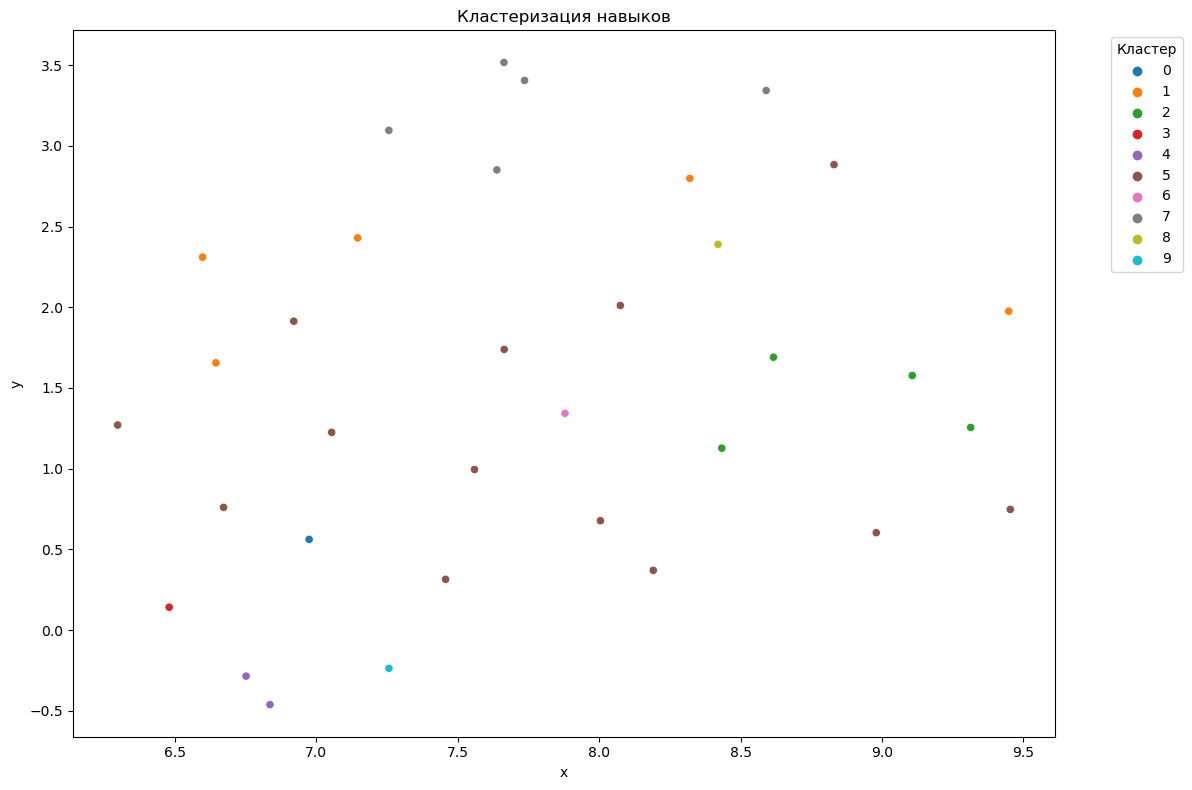

Извлеченные навыки из резюме: ['sql']


config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/57.4M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

Совпадения:
  candidate_skill job_requirement     score
1             sql             sql  0.955933
Важность навыков: {'python': 'medium', 'sql': 'medium', 'docker': 'medium', 'kubernetes': 'medium'}


In [11]:
import os
os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)

import pandas as pd
import numpy as np
import re

# Monkey patch for OpenBLAS bug in threadpoolctl (temporary fix)
import threadpoolctl
threadpoolctl._ThreadpoolInfo._load_modules = lambda self: setattr(self, 'modules', [])

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
# === Убедитесь, что установлены необходимые зависимости ===
# pip install sentence-transformers
# pip install setuptools wheel
# pip install spacy

import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

# Импорт с проверкой наличия библиотеки UMAP
try:
    import umap
except ImportError:
    raise ImportError("UMAP не установлен. Установите пакет с помощью: pip install umap-learn")

# Импорт с проверкой наличия spaCy
try:
    import spacy
    try:
        nlp = spacy.load("en_core_web_sm")
    except OSError:
        from spacy.cli import download
        download("en_core_web_sm")
        nlp = spacy.load("en_core_web_sm")
except ImportError:
    raise ImportError("spaCy не установлен. Установите с помощью: pip install spacy")

from sentence_transformers import SentenceTransformer, CrossEncoder

# === Конфигурация ===
MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'
CROSS_ENCODER_MODEL = 'cross-encoder/stsb-TinyBERT-L-4'
N_CLUSTERS = 10
RANDOM_STATE = 42

# === 1. Загрузка и подготовка данных из alliance_matrix.json ===
def load_skills_from_alliance(json_path: str) -> pd.DataFrame:
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    all_skills = []
    for role_id, role_data in data["roles"].items():
        for comp in role_data["competencies"]:
            skill_name = comp["name"].strip().lower()
            all_skills.append({
                "role": role_id,
                "group": comp["group"],
                "name": skill_name,
                "level_code": comp.get("required_level_code"),
                "level_name": comp.get("required_level_name")
            })

    df = pd.DataFrame(all_skills).drop_duplicates(subset=["name"])
    return df

# === 2. Векторизация навыков ===
def embed_skills(skills: pd.Series, model_name=MODEL_NAME) -> np.ndarray:
    model = SentenceTransformer(model_name)
    embeddings = model.encode(skills.tolist(), show_progress_bar=True)
    return embeddings

# === 3. Кластеризация навыков ===
def cluster_skills(embeddings: np.ndarray, n_clusters=N_CLUSTERS) -> np.ndarray:
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, batch_size=64)
    cluster_labels = kmeans.fit_predict(embeddings)
    return cluster_labels, kmeans

# === 4. Визуализация с понижением размерности ===
def visualize_clusters(embeddings: np.ndarray, labels: np.ndarray, skills: pd.Series):
    reducer = umap.UMAP(random_state=RANDOM_STATE)
    reduced = reducer.fit_transform(embeddings)
    df_vis = pd.DataFrame({
        'x': reduced[:, 0],
        'y': reduced[:, 1],
        'cluster': labels,
        'skill': skills
    })
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df_vis, x='x', y='y', hue='cluster', palette='tab10')
    plt.title('Кластеризация навыков')
    plt.legend(title='Кластер', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# === 5. Информационное извлечение из резюме ===
def extract_resume_skills(resume_text: str) -> list:
    doc = nlp(resume_text)
    skills = [ent.text.lower() for ent in doc.ents if ent.label_ in ['ORG', 'PRODUCT', 'SKILL']]
    return list(set(skills))

# === 6. Нормализация навыков ===
def normalize_skills(skills: list, synonyms_dict: dict) -> list:
    normalized = []
    for skill in skills:
        for norm, variants in synonyms_dict.items():
            if skill in variants:
                normalized.append(norm)
                break
        else:
            normalized.append(skill)
    return list(set(normalized))

# === 7. Семантическое сопоставление компетенций ===
def match_skills(candidate_skills: list, job_requirements: list) -> pd.DataFrame:
    model = CrossEncoder(CROSS_ENCODER_MODEL)
    pairs = [(c, j) for c in candidate_skills for j in job_requirements]
    scores = model.predict(pairs)
    df = pd.DataFrame(pairs, columns=['candidate_skill', 'job_requirement'])
    df['score'] = scores
    matched = df[df['score'] > 0.7]  # эмпирический порог
    return matched.sort_values(by='score', ascending=False)

# === 8. Оценка важности навыков в вакансии ===
def assess_skill_importance(job_description: str, skill_list: list) -> dict:
    importance = {}
    job_text = job_description.lower()
    for skill in skill_list:
        count = len(re.findall(r'\b' + re.escape(skill.lower()) + r'\b', job_text))
        if count >= 2:
            importance[skill] = 'high'
        elif count == 1:
            importance[skill] = 'medium'
        else:
            importance[skill] = 'low'
    return importance

# === 9. Основной пайплайн ===
def main():
    df_skills = load_skills_from_alliance('data/alliance_matrix.json')
    print(f"Загружено {len(df_skills)} уникальных навыков")

    embeddings = embed_skills(df_skills['name'])
    labels, kmeans_model = cluster_skills(embeddings)

    df_skills['cluster'] = labels
    df_skills.to_csv('data/clustered_skills.csv', index=False)

    joblib.dump(kmeans_model, 'models/skill_kmeans.pkl')
    np.save('models/skill_embeddings.npy', embeddings)

    visualize_clusters(embeddings, labels, df_skills['name'])

    # --- Пример извлечения и сопоставления ---
    # Создаём демо-файлы, если отсутствуют
    if not os.path.exists('data/sample_resume.txt'):
        with open('data/sample_resume.txt', 'w', encoding='utf-8') as f:
            f.write("""Senior Data Scientist with experience in Python, SQL, Docker, and machine learning deployment.""")

    if not os.path.exists('data/sample_job.txt'):
        with open('data/sample_job.txt', 'w', encoding='utf-8') as f:
            f.write("""We are looking for a data scientist skilled in Python, SQL, Docker, and Kubernetes.""")

    resume_text = open('data/sample_resume.txt', encoding='utf-8').read()
    job_description = open('data/sample_job.txt', encoding='utf-8').read()

    resume_skills = extract_resume_skills(resume_text)
    print("Извлеченные навыки из резюме:", resume_skills)

    # Предположим, есть словарь синонимов для нормализации
    skill_synonyms = {
        'python': ['python', 'python3', 'python 3.8'],
        'sql': ['sql', 'postgresql', 'mysql'],
        'docker': ['docker', 'docker-compose']
    }
    normalized_resume_skills = normalize_skills(resume_skills, skill_synonyms)

    # Список требований к вакансии (можно тоже парсить)
    job_requirements = ['python', 'sql', 'docker', 'kubernetes']

    matched_df = match_skills(normalized_resume_skills, job_requirements)
    print("Совпадения:")
    print(matched_df)

    importance = assess_skill_importance(job_description, job_requirements)
    print("Важность навыков:", importance)

if __name__ == '__main__':
    main()


In [14]:
import os
os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)

import pandas as pd
import numpy as np
import re
import json

# Monkey patch for OpenBLAS bug in threadpoolctl (temporary fix)
import threadpoolctl
threadpoolctl._ThreadpoolInfo._load_modules = lambda self: setattr(self, 'modules', [])

# === Убедитесь, что установлены необходимые зависимости ===
# pip install sentence-transformers
# pip install spacy
# python -m spacy download ru_core_news_md

# Импорт с проверкой наличия spaCy и русской модели
try:
    import spacy
    try:
        nlp = spacy.load("ru_core_news_md")
    except OSError:
        from spacy.cli import download
        download("ru_core_news_md")
        nlp = spacy.load("ru_core_news_md")
except ImportError:
    raise ImportError("spaCy не установлен. Установите с помощью: pip install spacy")

# === 1. Загрузка компетенций из alliance_matrix.json ===
def load_alliance_data(json_path: str) -> dict:
    with open(json_path, 'r', encoding='utf-8') as f:
        return json.load(f)

# === 2. Извлечение навыков из резюме (русский) ===
def extract_skills_ru(text: str) -> list:
    doc = nlp(text)
    tokens = [token.text.lower().strip() for token in doc if token.is_alpha and len(token.text) > 2]
    return list(set(tokens))

# === 3. Сравнение навыков кандидата с компетенциями роли ===
def match_competencies(candidate_skills: list, competencies: list) -> tuple:
    candidate_set = set(candidate_skills)
    required_skills = {comp['name'].lower().strip(): comp for comp in competencies}

    matched = []
    missing = []
    for skill_name, comp in required_skills.items():
        if skill_name in candidate_set:
            matched.append({
                "name": comp["name"],
                "importance": importance_level(comp.get("required_level_code", 1))
            })
        else:
            missing.append({"name": comp["name"]})

    extra = [
        {"name": skill}
        for skill in candidate_set
        if skill not in required_skills
    ]
    return matched, missing, extra

# === 4. Преобразование к уровню важности ===
def importance_level(code: int) -> str:
    return {1: "low", 2: "medium", 3: "high"}.get(code, "low")

# === 5. Выбор наилучшей роли ===
def find_best_matching_role(candidate_skills: list, alliance_data: dict) -> dict:
    best_score = -1
    best_result = {}

    for role_id, role_data in alliance_data["roles"].items():
        competencies = role_data["competencies"]
        matched, missing, extra = match_competencies(candidate_skills, competencies)

        score = len(matched) - len(missing)

        result = {
            "role_id": role_id,
            "role_name": role_data["name"],
            "matching": matched,
            "missing": missing,
            "extra": extra,
            "match_score": score
        }

        if score > best_score:
            best_score = score
            best_result = result

    return best_result

# === 6. Основной пайплайн ===
def main():
    alliance_path = 'data/alliance_matrix.json'
    resume_path = 'data/sample_resume_ru.txt'

    # Создаём заглушку резюме
    if not os.path.exists(resume_path):
        with open(resume_path, 'w', encoding='utf-8') as f:
            f.write("""Работал в области анализа данных, владею Python, SQL, умею работать с Docker и проводить A/B тесты.""")

    resume_text = open(resume_path, encoding='utf-8').read()
    candidate_skills = extract_skills_ru(resume_text)

    alliance_data = load_alliance_data(alliance_path)
    result = find_best_matching_role(candidate_skills, alliance_data)

    # Убираем служебное поле перед выводом
    result.pop("match_score", None)

    print(json.dumps(result, ensure_ascii=False, indent=2))

if __name__ == '__main__':
    main()

{}


In [ ]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)

import pandas as pd
import numpy as np
import re
import json
from docx import Document

# Импорт с проверкой наличия spaCy и русской модели
try:
    import spacy
    try:
        nlp = spacy.load("ru_core_news_md")
    except OSError:
        from spacy.cli import download
        download("ru_core_news_md")
        nlp = spacy.load("ru_core_news_md")
except ImportError:
    raise ImportError("spaCy не установлен. Установите с помощью: pip install spacy")

# === 1. Загрузка компетенций из alliance_matrix.json ===
def load_alliance_data(json_path: str) -> dict:
    with open(json_path, 'r', encoding='utf-8') as f:
        return json.load(f)

# === 2. Чтение .docx-файла резюме ===
def read_docx(path: str) -> str:
    doc = Document(path)
    return '\n'.join(p.text for p in doc.paragraphs if p.text.strip())

# === 3. Извлечение ключевых навыков из текста по ключевым словам ===
def extract_skills_by_keywords(text: str) -> list:
    potential_lines = re.findall(r'(Ключевые навыки:|Навыки:|Опыт:|Технологии:)?(.*)', text, flags=re.IGNORECASE)
    collected = ' '.join([line[1] for line in potential_lines if line[1]])
    skills = re.findall(r'[A-Za-zА-Яа-яё0-9\+\#\.\-]+', collected)
    return list(set([s.lower() for s in skills if len(s) > 1]))

# === 4. Сравнение навыков кандидата с компетенциями роли ===
def match_competencies(candidate_skills: list, competencies: list) -> tuple:
    candidate_set = set(candidate_skills)
    required_skills = {comp['name'].lower().strip(): comp for comp in competencies}

    matched = []
    missing = []
    for skill_name, comp in required_skills.items():
        if skill_name in candidate_set:
            matched.append({
                "name": comp["name"],
                "importance": importance_level(comp.get("required_level_code", 1))
            })
        else:
            missing.append({"name": comp["name"]})

    extra = [
        {"name": skill}
        for skill in candidate_set
        if skill not in required_skills
    ]
    return matched, missing, extra

# === 5. Преобразование к уровню важности ===
def importance_level(code: int) -> str:
    return {1: "low", 2: "medium", 3: "high"}.get(code, "low")

# === 6. Выбор наилучшей роли ===
def find_best_matching_role(candidate_skills: list, alliance_data: dict) -> dict:
    best_score = -1
    best_result = {}

    for role_id, role_data in alliance_data["roles"].items():
        competencies = role_data["competencies"]
        matched, missing, extra = match_competencies(candidate_skills, competencies)

        score = len(matched) - len(missing)

        result = {
            "role_id": role_id,
            "role_name": role_data["name"],
            "matching": matched,
            "missing": missing,
            "extra": extra,
            "match_score": score
        }

        if score > best_score:
            best_score = score
            best_result = result

    return best_result

# === 7. Основной пайплайн ===
def main():
    alliance_path = 'data/alliance_matrix.json'
    resume_path = 'data/резюметест.docx'

    if not os.path.exists(resume_path):
        raise FileNotFoundError("Файл резюме .docx не найден: data/резюметест.docx")

    text = read_docx(resume_path)
    candidate_skills = extract_skills_by_keywords(text)
    alliance_data = load_alliance_data(alliance_path)
    print("Извлечённые навыки:", candidate_skills)
    result = find_best_matching_role(candidate_skills, alliance_data)

    result.pop("match_score", None)

    print(json.dumps(result, ensure_ascii=False, indent=2))

if __name__ == '__main__':
    main()

Доступные роли: dict_keys(['DS_ML', 'DE', 'TA_AI', 'MGR_AI'])
Извлечённые навыки: ['ниу', 'сертификаты', 'стандарт', 'стандартов', '2024', '496н', 'данных', '2028', 'машинное', 'цель', 'проектах', 'данным', 'nlp', 'аккредитация', 'иванов', 'большим', 'специализация', 'текстов', 'образование', 'документация', '06.02', 'профстандартам', 'данные', 'c1', 'анализ', 'спроса', 'seaborn', 'рядов', 'предсказанию', 'петрович', 'математика', 'clickhouse', 'разработка', 'проектами', 'временных', 'scientist', 'agile', 'ооо', 'фокусом', 'science', 'топ-10', 'итмо', 'публикации', 'специалист', 'прогнозирования', 'обучение', 'matplotlib', 'tableau.', 'г.', 'опыт', 'участие', 'tensorflow', 'позицию', 'университет', 'scipy', 'информатика', 'программа', 'администрирование', 'моделей', 'pandas', '30', 'spark.', 'аналитик', 'трудоустройство', 'алексей', 'улучшение', 'postgresql', 'фио', 'точности', 'большие', 'python', 'обучение.', 'kaggle', 'numpy', 'прикладная', 'соответствует', '06.04.02', 'управление',

In [16]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)

import pandas as pd
import numpy as np
import re
import json
from docx import Document


# Импорт spaCy и загрузка русской модели
try:
    import spacy
    try:
        nlp = spacy.load("ru_core_news_md")
    except OSError:
        from spacy.cli import download
        download("ru_core_news_md")
        nlp = spacy.load("ru_core_news_md")
except ImportError:
    raise ImportError("spaCy не установлен. Установите с помощью: pip install spacy")

# === Загрузка компетенций из JSON ===
def load_alliance_data(json_path: str) -> dict:
    with open(json_path, 'r', encoding='utf-8') as f:
        return json.load(f)

# === Чтение .docx-файла резюме ===
def read_docx(path: str) -> str:
    doc = Document(path)
    return '\n'.join(p.text for p in doc.paragraphs if p.text.strip())

# === Извлечение навыков по ключевым словам ===
def extract_skills_by_keywords(text: str) -> list:
    potential_lines = re.findall(r'(Ключевые навыки:|Навыки:|Опыт:|Технологии:)?(.*)', text, flags=re.IGNORECASE)
    collected = ' '.join([line[1] for line in potential_lines if line[1]])
    skills = re.findall(r'[A-Za-zА-Яа-яё0-9\+\#\.\-]+', collected)
    return list(set([s.lower() for s in skills if len(s) > 1]))

# === Сравнение по словам ===
def keyword_overlap(skill_text: str, candidate_words: set) -> bool:
    skill_words = set(re.findall(r'\b\w+\b', skill_text.lower()))
    return len(skill_words & candidate_words) > 0

# === Сравнение навыков кандидата с компетенциями роли ===
def match_competencies(candidate_skills: list, competencies: list) -> tuple:
    candidate_words = set(candidate_skills)
    matched = []
    missing = []

    for comp in competencies:
        name = comp['name'].lower().strip()
        if keyword_overlap(name, candidate_words):
            matched.append({
                "name": comp["name"],
                "importance": importance_level(comp.get("required_level_code", 1))
            })
        else:
            missing.append({"name": comp["name"]})

    # Extra: candidate terms not covered by any competency
    all_known_words = set()
    for comp in competencies:
        all_known_words.update(re.findall(r'\b\w+\b', comp['name'].lower()))

    extra = [
        {"name": word} for word in candidate_words
        if word not in all_known_words
    ]
    return matched, missing, extra

# === Уровень значимости ===
def importance_level(code: int) -> str:
    return {1: "low", 2: "medium", 3: "high"}.get(code, "low")

# === Определение лучшей роли ===
def find_best_matching_role(candidate_skills: list, alliance_data: dict) -> dict:
    best_score = -1
    best_result = {}

    for role_id, role_data in alliance_data["roles"].items():
        competencies = role_data["competencies"]
        matched, missing, extra = match_competencies(candidate_skills, competencies)
        score = len(matched) - len(missing)

        result = {
            "role_id": role_id,
            "role_name": role_data["name"],
            "matching": matched,
            "missing": missing,
            "extra": extra,
            "match_score": score
        }

        if score > best_score:
            best_score = score
            best_result = result

    return best_result

# === Основной запуск ===
def main():
    alliance_path = 'data/alliance_matrix.json'
    resume_path = 'data/резюметест.docx'

    if not os.path.exists(resume_path):
        raise FileNotFoundError("Файл резюме .docx не найден: data/резюметест.docx")

    text = read_docx(resume_path)
    candidate_skills = extract_skills_by_keywords(text)
    alliance_data = load_alliance_data(alliance_path)
    print("Навыки кандидата:", alliance_data)
    result = find_best_matching_role(candidate_skills, alliance_data)
    result.pop("match_score", None)

    print(json.dumps(result, ensure_ascii=False, indent=2))

if __name__ == '__main__':
    main()

Навыки кандидата: {'roles': {'DS_ML': {'name': 'Аналитик данных (Data scientist, ml engineer)', 'description': 'Специалист, который работает с данными компании, анализирует их и разрабатывает решения на основе ИИ. Совместно с техническими аналитиками формирует технические метрики, которые зависят от бизнес-метрик...', 'competencies': [{'id': 'C01', 'group': 'Общие компетенции', 'name': 'Определения, история развития и главные тренды ИИ', 'required_level_code': 1, 'required_level_name': 'Базовый', 'relevant_industries': []}, {'id': 'C02', 'group': 'Общие компетенции', 'name': 'Процесс, стадии и методологии разработки решений на основе ИИ (Docker, Linux/Bash, Git)', 'required_level_code': 2, 'required_level_name': 'Продвинутый', 'relevant_industries': []}, {'id': 'C03', 'group': 'Общие компетенции', 'name': 'Статистические методы и первичный анализ данных', 'required_level_code': 2, 'required_level_name': 'Продвинутый', 'relevant_industries': []}, {'id': 'C04', 'group': 'Общие компетенци

In [18]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)

import pandas as pd
import numpy as np
import re
import json
from docx import Document

# Импорт spaCy и загрузка русской модели
try:
    import spacy
    try:
        nlp = spacy.load("ru_core_news_md")
    except OSError:
        from spacy.cli import download
        download("ru_core_news_md")
        nlp = spacy.load("ru_core_news_md")
except ImportError:
    raise ImportError("spaCy не установлен. Установите с помощью: pip install spacy")

# === Загрузка компетенций из JSON ===
def load_alliance_data(json_path: str) -> dict:
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    # Проверяем, есть ли ключ "roles" — именно там хранятся роли с компетенциями
    if "roles" not in data:
        raise KeyError("В JSON отсутствует ключ 'roles'")
    return data["roles"]  # Возвращаем сразу словарь ролей

# === Чтение .docx-файла резюме ===
def read_docx(path: str) -> str:
    doc = Document(path)
    return '\n'.join(p.text for p in doc.paragraphs if p.text.strip())

# === Извлечение навыков по ключевым словам ===
def extract_skills_by_keywords(text: str) -> list:
    potential_lines = re.findall(r'(Ключевые навыки:|Навыки:|Опыт:|Технологии:)?(.*)', text, flags=re.IGNORECASE)
    collected = ' '.join([line[1] for line in potential_lines if line[1]])
    skills = re.findall(r'[A-Za-zА-Яа-яё0-9\+\#\.\-]+', collected)
    return list(set([s.lower() for s in skills if len(s) > 1]))

# === Сравнение по словам ===
def keyword_overlap(skill_text: str, candidate_words: set) -> bool:
    skill_words = set(re.findall(r'\b\w+\b', skill_text.lower()))
    return len(skill_words & candidate_words) > 0

# === Сравнение навыков кандидата с компетенциями роли ===
def match_competencies(candidate_skills: list, competencies: list) -> tuple:
    candidate_words = set(candidate_skills)
    matched = []
    missing = []

    for comp in competencies:
        name = comp['name'].lower().strip()
        if keyword_overlap(name, candidate_words):
            matched.append({
                "name": comp["name"],
                "importance": importance_level(comp.get("required_level_code", 1))
            })
        else:
            missing.append({"name": comp["name"]})

    # Extra: candidate terms not covered by any competency
    all_known_words = set()
    for comp in competencies:
        all_known_words.update(re.findall(r'\b\w+\b', comp['name'].lower()))

    extra = [
        {"name": word} for word in candidate_words
        if word not in all_known_words
    ]
    return matched, missing, extra

# === Уровень значимости ===
def importance_level(code: int) -> str:
    return {1: "low", 2: "medium", 3: "high"}.get(code, "low")

# === Определение лучшей роли ===
def find_best_matching_role(candidate_skills: list, roles: dict) -> dict:
    best_score = -1
    best_result = {}

    for role_id, role_data in roles.items():
        competencies = role_data.get("competencies", [])
        matched, missing, extra = match_competencies(candidate_skills, competencies)
        score = len(matched) - len(missing)

        result = {
            "role_id": role_id,
            "role_name": role_data.get("name", ""),
            "matching": matched,
            "missing": missing,
            "extra": extra,
            "match_score": score
        }

        if score > best_score:
            best_score = score
            best_result = result

    return best_result

# === Основной запуск ===
def main():
    alliance_path = 'data/alliance_matrix.json'
    resume_path = 'data/резюметест.docx'

    if not os.path.exists(resume_path):
        raise FileNotFoundError("Файл резюме .docx не найден: data/резюметест.docx")

    text = read_docx(resume_path)
    candidate_skills = extract_skills_by_keywords(text)
    roles = load_alliance_data(alliance_path)  # Теперь загружаем сразу roles из JSON
    result = find_best_matching_role(candidate_skills, roles)
    result.pop("match_score", None)

    print(json.dumps(result, ensure_ascii=False, indent=2))

if __name__ == '__main__':
    main()


{}


In [19]:
resume_text = """
ФИО: Иванов Алексей Петрович
Цель: Трудоустройство на позицию Data Scientist / Аналитик данных с фокусом на машинное обучение и большие данные.
Ключевые навыки:
Анализ данных: Python (Pandas, NumPy, SciPy), SQL, Apache Spark.
Машинное обучение: Scikit-learn, TensorFlow, NLP, компьютерное зрение.
Визуализация: Matplotlib, Seaborn, Tableau.
Управление проектами: Agile, Jira.
Знание профессиональных стандартов:
«Специалист по большим данным» (Приказ Минтруда № 496н).
«Системный аналитик» (06.02).
Образование:
НИУ ВШЭ / Университет ИТМО
Программа: Прикладная математика и информатика (01.03.02).
Специализация: Большие данные и машинное обучение.
Аккредитация: до 2028 г. (соответствует профстандартам).
Опыт (пример):
Аналитик данных (ООО «ТехноСистемы», 2022–2024):
Разработка моделей прогнозирования спроса (улучшение точности на 30%).
Администрирование DWH (PostgreSQL, ClickHouse).
Участие в проектах по NLP (классификация текстов).
Сертификаты:
«Специалист по Data Science» (НИУ ВШЭ, 2024).
«Профессиональный стандарт 06.04.02» (большие данные).
Дополнительно:
Английский: C1 (техническая документация).
Публикации на Kaggle (ТОП-10% в конкурсе по предсказанию временных рядов).
"""
# Извлечь навыки из текста резюме
candidate_skills = extract_skills_by_keywords(resume_text)
print("Извлечённые навыки:", candidate_skills)

# Загрузить роли из JSON (примерно, должен быть загружен твой файл с ролями)
roles = load_alliance_data('data/alliance_matrix.json')

# Найти лучшую роль
result = find_best_matching_role(candidate_skills, roles)
result.pop("match_score", None)  # чтобы убрать внутреннее поле

# Вывести результат
print(json.dumps(result, ensure_ascii=False, indent=2))


Извлечённые навыки: ['ниу', 'сертификаты', 'стандарт', 'стандартов', '2024', '496н', 'данных', '2028', 'машинное', 'цель', 'проектах', 'данным', 'nlp', 'аккредитация', 'иванов', 'большим', 'специализация', 'текстов', 'образование', 'документация', '06.02', 'профстандартам', 'данные', 'c1', 'анализ', 'спроса', 'seaborn', 'рядов', 'предсказанию', 'петрович', 'математика', 'clickhouse', 'разработка', 'проектами', 'временных', 'scientist', 'agile', 'ооо', 'фокусом', 'science', 'топ-10', 'итмо', 'публикации', 'специалист', 'прогнозирования', 'обучение', 'matplotlib', 'tableau.', 'г.', 'опыт', 'участие', 'tensorflow', 'позицию', 'университет', 'scipy', 'информатика', 'программа', 'администрирование', 'моделей', 'pandas', '30', 'spark.', 'аналитик', 'трудоустройство', 'алексей', 'улучшение', 'postgresql', 'фио', 'точности', 'большие', 'python', 'обучение.', 'kaggle', 'numpy', 'прикладная', 'соответствует', '06.04.02', 'управление', 'визуализация', 'техническая', 'apache', 'приказ', '2022', 'д

In [21]:
import os
import re
import json
from docx import Document

# === Функция загрузки JSON с ролями и компетенциями ===
def load_alliance_data(json_path: str) -> dict:
    with open(json_path, 'r', encoding='utf-8') as f:
        return json.load(f)

# === Чтение .docx (если надо, сейчас можно заменить на строку) ===
def read_docx(path: str) -> str:
    doc = Document(path)
    return '\n'.join(p.text for p in doc.paragraphs if p.text.strip())

# === Улучшенное извлечение навыков из текста резюме ===
def extract_skills_by_keywords(text: str) -> list:
    lines = re.findall(r'(Ключевые навыки:|Навыки:|Опыт:|Технологии:)(.*)', text, flags=re.IGNORECASE)
    skills = []
    for _, skill_line in lines:
        parts = re.split(r'[;,]', skill_line)
        for part in parts:
            skill = part.strip().lower()
            if skill:
                skills.append(skill)
    return list(set(skills))

# === Уровень важности ===
def importance_level(code: int) -> str:
    return {1: "low", 2: "medium", 3: "high"}.get(code, "low")

# === Сопоставление навыков кандидата с компетенциями ===
def match_competencies(candidate_skills: list, competencies: list) -> tuple:
    matched = []
    missing = []

    for comp in competencies:
        comp_name = comp['name'].lower()
        found = False
        for skill in candidate_skills:
            if skill in comp_name or comp_name in skill:
                matched.append({
                    "name": comp["name"],
                    "importance": importance_level(comp.get("required_level_code", 1))
                })
                found = True
                break
        if not found:
            missing.append({"name": comp["name"]})

    comp_names = [c['name'].lower() for c in competencies]
    extra = []
    for skill in candidate_skills:
        if not any(skill in comp_name or comp_name in skill for comp_name in comp_names):
            extra.append({"name": skill})

    return matched, missing, extra

# === Поиск лучшей роли ===
def find_best_matching_role(candidate_skills: list, alliance_data: dict) -> dict:
    best_score = -1
    best_result = {}

    for role_id, role_data in alliance_data["roles"].items():
        competencies = role_data.get("competencies", [])
        matched, missing, extra = match_competencies(candidate_skills, competencies)
        score = len(matched) - len(missing)  # простая метрика

        result = {
            "role_id": role_id,
            "role_name": role_data["name"],
            "matching": matched,
            "missing": missing,
            "extra": extra,
            "match_score": score
        }

        if score > best_score:
            best_score = score
            best_result = result

    return best_result

# === Пример реального резюме (можно заменить на чтение из файла) ===
resume_text = """
ФИО: Иванов Алексей Петрович
Цель: Трудоустройство на позицию Data Scientist / Аналитик данных с фокусом на машинное обучение и большие данные.
Ключевые навыки:
Анализ данных: Python (Pandas, NumPy, SciPy), SQL, Apache Spark.
Машинное обучение: Scikit-learn, TensorFlow, NLP, компьютерное зрение.
Визуализация: Matplotlib, Seaborn, Tableau.
Управление проектами: Agile, Jira.
"""

def main():
    alliance_path = 'data/alliance_matrix.json'

    # Загрузка данных о ролях и компетенциях
    alliance_data = load_alliance_data(alliance_path)

    # Извлечение навыков из резюме
    candidate_skills = extract_skills_by_keywords(resume_text)
    print("Извлечённые навыки кандидата:")
    print(candidate_skills)

    # Поиск лучшей роли по компетенциям
    result = find_best_matching_role(candidate_skills, alliance_data)
    result.pop("match_score", None)

    print("\nЛучшее совпадение с ролью и компетенциями:")
    print(json.dumps(result, ensure_ascii=False, indent=2))

if __name__ == '__main__':
    main()


Извлечённые навыки кандидата:
[]

Лучшее совпадение с ролью и компетенциями:
{}


In [23]:
import os
import re
import json
from docx import Document

# === Функция загрузки JSON с ролями и компетенциями ===
def load_alliance_data(json_path: str) -> dict:
    with open(json_path, 'r', encoding='utf-8') as f:
        return json.load(f)

# === Чтение .docx (если надо, сейчас можно заменить на строку) ===
def read_docx(path: str) -> str:
    doc = Document(path)
    return '\n'.join(p.text for p in doc.paragraphs if p.text.strip())

# === Улучшенное извлечение навыков из текста резюме ===
def extract_skills_by_keywords(text: str) -> list:
    pattern = re.compile(r'(Ключевые навыки:|Навыки:)(.+?)(?:\n\n|\Z)', re.IGNORECASE | re.DOTALL)
    match = pattern.search(text)
    if not match:
        return []

    skills_block = match.group(2)

    skills = []
    for line in skills_block.split('\n'):
        if ':' in line:
            line = line.split(':', 1)[1]
        parts = re.split(r'[;,]', line)
        for part in parts:
            skill = part.strip().lower()

            # Удаляем скобки и содержимое внутри
            skill = re.sub(r'\(.*?\)', '', skill)

            # Удаляем точки и лишние пробелы
            skill = skill.replace('.', '').strip()

            if skill:
                skills.append(skill)

    # Возвращаем уникальные и отсортированные для удобства
    return sorted(list(set(skills)))



# === Уровень важности ===
def importance_level(code: int) -> str:
    return {1: "low", 2: "medium", 3: "high"}.get(code, "low")

# === Сопоставление навыков кандидата с компетенциями ===
def match_competencies(candidate_skills: list, competencies: list) -> tuple:
    matched = []
    missing = []

    # Приводим компетенции к нижнему регистру
    competencies_lower = [{**comp, "name_lower": comp['name'].lower()} for comp in competencies]

    for comp in competencies_lower:
        comp_name = comp["name_lower"]
        found = False
        for skill in candidate_skills:
            # Проверяем пересечение слов
            comp_words = set(comp_name.split())
            skill_words = set(skill.split())
            if comp_words & skill_words:
                matched.append({
                    "name": comp["name"],
                    "importance": importance_level(comp.get("required_level_code", 1))
                })
                found = True
                break
        if not found:
            missing.append({"name": comp["name"]})

    # Extra — навыки кандидата, которые не сопоставились ни с одной компетенцией
    comp_names_set = set(comp["name_lower"] for comp in competencies_lower)
    extra = [ {"name": skill} for skill in candidate_skills if not any(skill in comp_name or comp_name in skill for comp_name in comp_names_set) ]

    return matched, missing, extra


# === Поиск лучшей роли ===
def find_best_matching_role(candidate_skills: list, alliance_data: dict) -> dict:
    best_score = -1
    best_result = {}

    for role_id, role_data in alliance_data["roles"].items():
        competencies = role_data.get("competencies", [])
        matched, missing, extra = match_competencies(candidate_skills, competencies)
        score = len(matched) - len(missing)  # простая метрика

        result = {
            "role_id": role_id,
            "role_name": role_data["name"],
            "matching": matched,
            "missing": missing,
            "extra": extra,
            "match_score": score
        }

        if score > best_score:
            best_score = score
            best_result = result

    return best_result

# === Пример реального резюме (можно заменить на чтение из файла) ===
resume_text = """
ФИО: Иванов Алексей Петрович
Цель: Трудоустройство на позицию Data Scientist / Аналитик данных с фокусом на машинное обучение и большие данные.
Ключевые навыки:
Анализ данных: Python (Pandas, NumPy, SciPy), SQL, Apache Spark.
Машинное обучение: Scikit-learn, TensorFlow, NLP, компьютерное зрение.
Визуализация: Matplotlib, Seaborn, Tableau.
Управление проектами: Agile, Jira.
"""

def main():
    alliance_path = 'data/alliance_matrix.json'

    # Загрузка данных о ролях и компетенциях
    alliance_data = load_alliance_data(alliance_path)

    # Извлечение навыков из резюме
    candidate_skills = extract_skills_by_keywords(resume_text)
    print("Извлечённые навыки кандидата:")
    print(candidate_skills)

    # Поиск лучшей роли по компетенциям
    result = find_best_matching_role(candidate_skills, alliance_data)
    result.pop("match_score", None)

    print("\nЛучшее совпадение с ролью и компетенциями:")
    print(json.dumps(result, ensure_ascii=False, indent=2))

if __name__ == '__main__':
    main()


Извлечённые навыки кандидата:
['agile', 'apache spark', 'jira', 'matplotlib', 'nlp', 'numpy', 'python (pandas', 'scikit-learn', 'scipy)', 'seaborn', 'sql', 'tableau', 'tensorflow', 'компьютерное зрение']

Лучшее совпадение с ролью и компетенциями:
{}


In [25]:
import os
import re
import json
from docx import Document

# === Функция загрузки JSON с ролями и компетенциями ===
def load_alliance_data(json_path: str) -> dict:
    with open(json_path, 'r', encoding='utf-8') as f:
        return json.load(f)

# === Чтение .docx (если надо, сейчас можно заменить на строку) ===
def read_docx(path: str) -> str:
    doc = Document(path)
    return '\n'.join(p.text for p in doc.paragraphs if p.text.strip())

# === Улучшенное извлечение навыков из текста резюме ===
def extract_skills_by_keywords(text: str) -> list:
    pattern = re.compile(r'(Ключевые навыки:|Навыки:)(.+?)(?:\n\n|\Z)', re.IGNORECASE | re.DOTALL)
    match = pattern.search(text)
    if not match:
        return []

    skills_block = match.group(2)

    skills = []
    for line in skills_block.split('\n'):
        if ':' in line:
            line = line.split(':', 1)[1]
        parts = re.split(r'[;,]', line)
        for part in parts:
            skill = part.strip().lower()

            # Удаляем скобки и содержимое внутри
            skill = re.sub(r'\(.*?\)', '', skill)

            # Удаляем точки и лишние пробелы
            skill = skill.replace('.', '').strip()

            if skill:
                skills.append(skill)

    # Возвращаем уникальные и отсортированные для удобства
    return sorted(list(set(skills)))



# === Уровень важности ===
def importance_level(code: int) -> str:
    return {1: "low", 2: "medium", 3: "high"}.get(code, "low")

# === Сопоставление навыков кандидата с компетенциями ===
def match_competencies(candidate_skills: list, competencies: list) -> tuple:
    matched = []
    missing = []

    # Приводим все к нижнему регистру для корректного сравнения
    candidate_skills_lower = [skill.lower() for skill in candidate_skills]

    for comp in competencies:
        comp_name_lower = comp['name'].lower()
        found = False
        for skill in candidate_skills_lower:
            # Проверяем, входит ли навык в компетенцию или наоборот
            if skill in comp_name_lower or comp_name_lower in skill:
                matched.append({
                    "name": comp["name"],
                    "importance": importance_level(comp.get("required_level_code", 1))
                })
                found = True
                break
        if not found:
            missing.append({"name": comp["name"]})

    # Навыки кандидата, которые не входят ни в одну компетенцию
    extra = []
    for skill in candidate_skills_lower:
        if not any(skill in comp['name'].lower() or comp['name'].lower() in skill for comp in competencies):
            extra.append({"name": skill})

    return matched, missing, extra



# === Поиск лучшей роли ===
def find_best_matching_role(candidate_skills: list, alliance_data: dict) -> dict:
    best_score = -1
    best_result = {}

    for role_id, role_data in alliance_data["roles"].items():
        competencies = role_data.get("competencies", [])
        matched, missing, extra = match_competencies(candidate_skills, competencies)
        score = len(matched) - len(missing)  # простая метрика

        result = {
            "role_id": role_id,
            "role_name": role_data["name"],
            "matching": matched,
            "missing": missing,
            "extra": extra,
            "match_score": score
        }

        if score > best_score:
            best_score = score
            best_result = result

    return best_result

# === Пример реального резюме (можно заменить на чтение из файла) ===
resume_text = """
ФИО: Иванов Алексей Петрович
Цель: Трудоустройство на позицию Data Scientist / Аналитик данных с фокусом на машинное обучение и большие данные.
Ключевые навыки:
Анализ данных: Python (Pandas, NumPy, SciPy), SQL, Apache Spark.
Машинное обучение: Scikit-learn, TensorFlow, NLP, компьютерное зрение.
Визуализация: Matplotlib, Seaborn, Tableau.
Управление проектами: Agile, Jira.
"""

def main():
    alliance_path = 'data/alliance_matrix.json'

    # Загрузка данных о ролях и компетенциях
    alliance_data = load_alliance_data(alliance_path)

    # Извлечение навыков из резюме
    candidate_skills = extract_skills_by_keywords(resume_text)
    print("Извлечённые навыки кандидата:")
    print(candidate_skills)

    # Поиск лучшей роли по компетенциям
    result = find_best_matching_role(candidate_skills, alliance_data)
    result.pop("match_score", None)

    print("\nЛучшее совпадение с ролью и компетенциями:")
    print(json.dumps(result, ensure_ascii=False, indent=2))

if __name__ == '__main__':
    main()


Извлечённые навыки кандидата:
['agile', 'apache spark', 'jira', 'matplotlib', 'nlp', 'numpy', 'python (pandas', 'scikit-learn', 'scipy)', 'seaborn', 'sql', 'tableau', 'tensorflow', 'компьютерное зрение']

Лучшее совпадение с ролью и компетенциями:
{}


In [28]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)

import re
import json
from docx import Document

# Импорт spaCy и загрузка русской модели
try:
    import spacy
    try:
        nlp = spacy.load("ru_core_news_md")
    except OSError:
        from spacy.cli import download
        download("ru_core_news_md")
        nlp = spacy.load("ru_core_news_md")
except ImportError:
    raise ImportError("spaCy не установлен. Установите с помощью: pip install spacy")


def load_alliance_data(json_path: str) -> dict:
    with open(json_path, 'r', encoding='utf-8') as f:
        return json.load(f)


def read_docx(path: str) -> str:
    doc = Document(path)
    return '\n'.join(p.text for p in doc.paragraphs if p.text.strip())


def extract_skills_by_keywords(text: str) -> list:
    # Ищем блок с навыками
    pattern = re.compile(r'(Ключевые навыки:|Навыки:)(.+?)(?:\n\n|\Z)', re.IGNORECASE | re.DOTALL)
    match = pattern.search(text)
    if not match:
        return []

    skills_block = match.group(2)

    skills = []
    for line in skills_block.split('\n'):
        # Убираем часть перед ":"
        if ':' in line:
            line = line.split(':', 1)[1]
        # Делим по запятой и точке с запятой
        parts = re.split(r'[;,]', line)
        for part in parts:
            skill = part.strip().lower()

            # Удаляем скобки и содержимое внутри
            skill = re.sub(r'\(.*?\)', '', skill)

            # Удаляем точки и лишние пробелы
            skill = skill.replace('.', '').strip()

            if skill:
                skills.append(skill)

    return sorted(list(set(skills)))


def importance_level(code: int) -> str:
    return {1: "low", 2: "medium", 3: "high"}.get(code, "low")


def match_competencies(candidate_skills: list, competencies: list) -> tuple:
    matched = []
    missing = []

    candidate_skills_lower = [skill.lower() for skill in candidate_skills]

    for comp in competencies:
        comp_name_lower = comp['name'].lower()
        found = False
        for skill in candidate_skills_lower:
            if skill in comp_name_lower or comp_name_lower in skill:
                matched.append({
                    "name": comp["name"],
                    "importance": importance_level(comp.get("required_level_code", 1))
                })
                found = True
                break
        if not found:
            missing.append({"name": comp["name"]})

    extra = []
    for skill in candidate_skills_lower:
        if not any(skill in comp['name'].lower() or comp['name'].lower() in skill for comp in competencies):
            extra.append({"name": skill})

    return matched, missing, extra


def find_best_matching_role(candidate_skills: list, alliance_data: dict) -> dict:
    best_score = -1
    best_result = {}

    for role_id, role_data in alliance_data["roles"].items():
        competencies = role_data.get("competencies", [])
        matched, missing, extra = match_competencies(candidate_skills, competencies)
        score = len(matched) - len(missing)

        result = {
            "role_id": role_id,
            "role_name": role_data["name"],
            "matching": matched,
            "missing": missing,
            "extra": extra,
            "match_score": score
        }

        if score > best_score:
            best_score = score
            best_result = result

    return best_result


def main():
    alliance_path = 'data/alliance_matrix.json'
    resume_path = 'data/резюметест.docx'

    if not os.path.exists(resume_path):
        raise FileNotFoundError("Файл резюме .docx не найден: data/резюметест.docx")

    text = read_docx(resume_path)
    candidate_skills = extract_skills_by_keywords(text)
    print("Извлечённые навыки кандидата:")
    print(candidate_skills)

    alliance_data = load_alliance_data(alliance_path)

    result = find_best_matching_role(candidate_skills, alliance_data)
    if result:
        result.pop("match_score", None)
    else:
        print("Лучшее совпадение не найдено")

    print("\nЛучшее совпадение с ролью и компетенциями:")
    print(json.dumps(result, ensure_ascii=False, indent=2))


if __name__ == '__main__':
    main()


Извлечённые навыки кандидата:
['2024)', 'agile', 'apache spark', 'c1', 'clickhouse)', 'jira', 'matplotlib', 'nlp', 'numpy', 'python (pandas', 'scikit-learn', 'scipy)', 'seaborn', 'sql', 'tableau', 'tensorflow', '«профессиональный стандарт 060402»', '«системный аналитик»', '«специалист по data science» (ниу вшэ', '«специалист по большим данным»', 'администрирование dwh (postgresql', 'большие данные и машинное обучение', 'до 2028 г', 'компьютерное зрение', 'ниу вшэ / университет итмо', 'прикладная математика и информатика', 'публикации на kaggle', 'разработка моделей прогнозирования спроса', 'участие в проектах по nlp']
Лучшее совпадение не найдено

Лучшее совпадение с ролью и компетенциями:
{}


Загружено уникальных навыков: 34


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\neuty\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\neuty\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


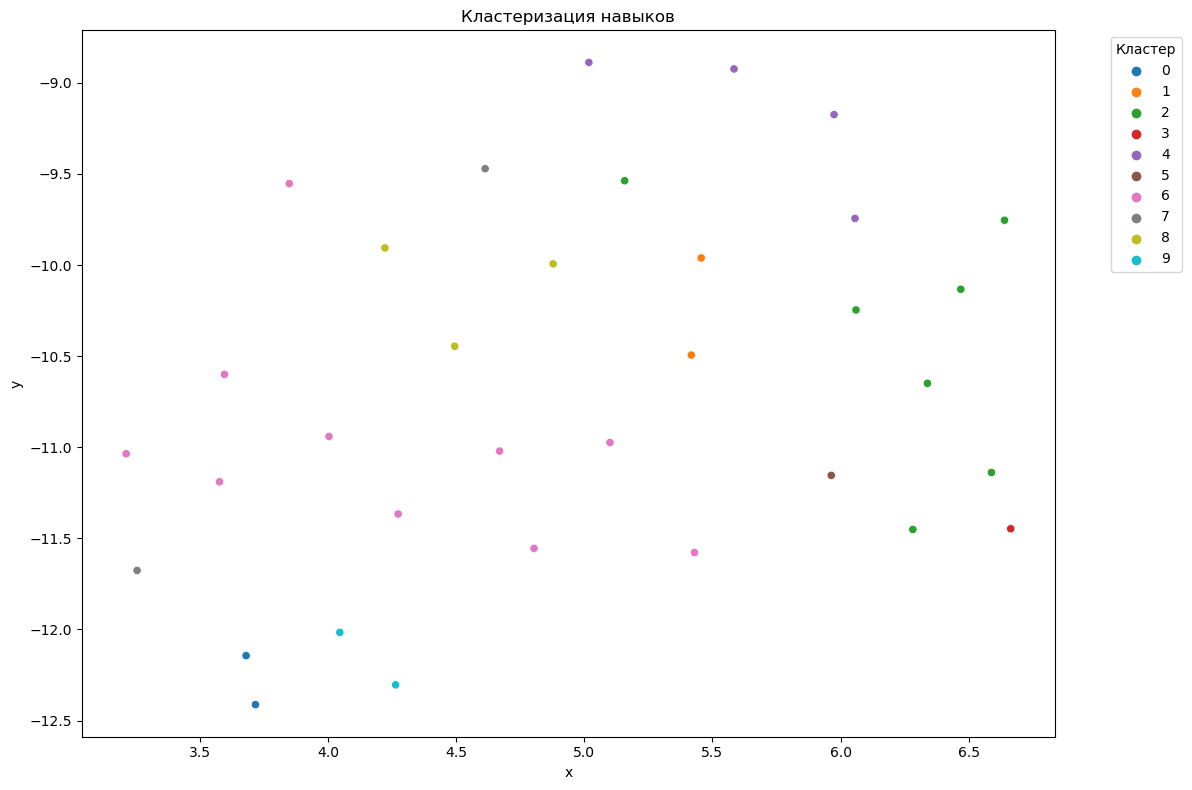

Извлечённые навыки из резюме: ['apache spark', 'английский: c1', 'clickhouse', 'публикации на kaggle', 'аналитик', 'вшэ', 'специализация: большие данные и машинное обучение', 'scipy)', 'машинное обучение: scikit-learn', 'иванов алексей петрович цель', '«специалист по большим данным»', 'ооо', 'участие в проектах по nlp', 'фио', 'clickhouse)', 'сертификаты:', 'специалист', 'data scientist / аналитик', 'nlp', 'numpy', '2022–2024):', 'jira', 'разработка моделей прогнозирования спроса', 'дополнительно:', 'образование:', 'программа: прикладная математика и информатика', 'ниу вшэ / университет итмо', 'tensorflow', 'управление проектами: agile', 'sql', 'знание профессиональных стандартов:', 'администрирование dwh', 'анализ данных: python (pandas', 'техносистемы', 'опыт :', 'администрирование dwh (postgresql', '«специалист по data science» (ниу вшэ', '2024)', 'аналитик данных (ооо «техносистемы»', 'аккредитация: до 2028 г', 'seaborn', '«профессиональный стандарт 060402»', 'компьютерное зрение',

In [35]:
import os
os.makedirs('models', exist_ok=True)
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

import re
import json
import pandas as pd
import numpy as np

from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sentence_transformers import SentenceTransformer
from sentence_transformers.cross_encoder import CrossEncoder


try:
    import spacy
except ImportError:
    raise ImportError("Установите spaCy: pip install spacy")

try:
    import umap
except ImportError:
    raise ImportError("Установите umap-learn: pip install umap-learn")

from sentence_transformers import SentenceTransformer


# === Конфигурация ===
MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'
CROSS_ENCODER_MODEL = 'cross-encoder/stsb-TinyBERT-L-4'
N_CLUSTERS = 10
RANDOM_STATE = 42

# === NLP модель ===
nlp = spacy.load("en_core_web_sm")

# === 1. Загрузка навыков из alliance_matrix.json ===
def load_skills_from_alliance(json_path: str) -> pd.DataFrame:
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    all_skills = []
    for role_id, role_data in data["roles"].items():
        for comp in role_data.get("competencies", []):
            skill_name = comp["name"].strip().lower()
            all_skills.append({
                "role": role_id,
                "group": comp.get("group", ""),
                "name": skill_name,
                "level_code": comp.get("required_level_code", 1),
                "level_name": comp.get("required_level_name", "low")
            })

    df = pd.DataFrame(all_skills).drop_duplicates(subset=["name"]).reset_index(drop=True)
    return df

# === 2. Векторизация навыков ===
def embed_skills(skills: pd.Series, model_name=MODEL_NAME) -> np.ndarray:
    model = SentenceTransformer(model_name)
    embeddings = model.encode(skills.tolist(), show_progress_bar=True)
    return embeddings

# === 3. Кластеризация навыков ===
def cluster_skills(embeddings: np.ndarray, n_clusters=N_CLUSTERS) -> tuple:
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, batch_size=64)
    cluster_labels = kmeans.fit_predict(embeddings)
    return cluster_labels, kmeans

# === 4. Визуализация ===
def visualize_clusters(embeddings: np.ndarray, labels: np.ndarray, skills: pd.Series):
    reducer = umap.UMAP(random_state=RANDOM_STATE)
    reduced = reducer.fit_transform(embeddings)
    df_vis = pd.DataFrame({
        'x': reduced[:, 0],
        'y': reduced[:, 1],
        'cluster': labels,
        'skill': skills
    })
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df_vis, x='x', y='y', hue='cluster', palette='tab10')
    plt.title('Кластеризация навыков')
    plt.legend(title='Кластер', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# === 5. Извлечение навыков из резюме: поиск по ключевым словам + NER ===
def extract_resume_skills(resume_text: str) -> list:
    # Простейшее регулярное извлечение "Ключевые навыки" (если есть)
    pattern = re.compile(r'(Ключевые навыки:|Навыки:)(.+?)(?:\n\n|\Z)', re.IGNORECASE | re.DOTALL)
    match = pattern.search(resume_text)
    skills_from_text = []
    if match:
        block = match.group(2)
        for line in block.split('\n'):
            # делим по запятым, точкам с запятой
            parts = re.split(r'[;,]', line)
            for part in parts:
                skill = part.strip().lower()
                # удаляем скобки и их содержимое
                skill = re.sub(r'\(.*?\)', '', skill)
                skill = skill.replace('.', '').strip()
                if skill:
                    skills_from_text.append(skill)

    # Дополнительно извлекаем сущности NER из spaCy
    doc = nlp(resume_text)
    ner_skills = [ent.text.lower() for ent in doc.ents if ent.label_ in ['ORG', 'PRODUCT', 'SKILL']]

    combined = set(skills_from_text + ner_skills)
    return list(combined)

# === 6. Нормализация навыков через словарь синонимов ===
def normalize_skills(skills: list, synonyms_dict: dict) -> list:
    normalized = []
    for skill in skills:
        found_norm = False
        for norm, variants in synonyms_dict.items():
            if any(variant in skill for variant in variants):
                normalized.append(norm)
                found_norm = True
                break
        if not found_norm:
            normalized.append(skill)
    return list(set(normalized))

# === 7. Сопоставление навыков кандидата и требований вакансии с учетом in ===
def match_skills(candidate_skills: list, job_requirements: list) -> pd.DataFrame:
    # Используем cross-encoder для оценки релевантности пар (если модель доступна)
    model = CrossEncoder(CROSS_ENCODER_MODEL)
    pairs = [(c, j) for c in candidate_skills for j in job_requirements]
    scores = model.predict(pairs)

    df = pd.DataFrame(pairs, columns=['candidate_skill', 'job_requirement'])
    df['score'] = scores

    # Фильтруем по порогу релевантности
    matched = df[df['score'] > 0.7]

    # Если не хватает совпадений, пробуем простое вхождение (in) для расширения
    if matched.empty:
        matched_rows = []
        for c in candidate_skills:
            for j in job_requirements:
                if c in j or j in c:
                    matched_rows.append({'candidate_skill': c, 'job_requirement': j, 'score': 1.0})
        matched = pd.DataFrame(matched_rows)

    return matched.sort_values(by='score', ascending=False)

# === 8. Оценка важности навыков по описанию вакансии ===
def assess_skill_importance(job_description: str, skill_list: list) -> dict:
    importance = {}
    job_text = job_description.lower()
    for skill in skill_list:
        # Подсчет количества вхождений навыка в описание вакансии
        count = len(re.findall(r'\b' + re.escape(skill.lower()) + r'\b', job_text))
        if count >= 2:
            importance[skill] = 'high'
        elif count == 1:
            importance[skill] = 'medium'
        else:
            importance[skill] = 'low'
    return importance

# === 9. Основной пайплайн ===
def main():
    # --- Загрузка навыков и кластеризация ---
    alliance_json_path = 'data/alliance_matrix.json'
    df_skills = load_skills_from_alliance(alliance_json_path)
    print(f"Загружено уникальных навыков: {len(df_skills)}")

    embeddings = embed_skills(df_skills['name'])
    labels, kmeans_model = cluster_skills(embeddings)

    df_skills['cluster'] = labels
    df_skills.to_csv('data/clustered_skills.csv', index=False, encoding='utf-8')

    joblib.dump(kmeans_model, 'models/skill_kmeans.pkl')
    np.save('models/skill_embeddings.npy', embeddings)

    visualize_clusters(embeddings, labels, df_skills['name'])

    # --- Обработка резюме и вакансии ---
    with open('data/sample_resume_ru.txt', encoding='utf-8') as f:
        resume_text = f.read()
    with open('data/sample_job.txt', encoding='utf-8') as f:
        job_description = f.read()

    resume_skills = extract_resume_skills(resume_text)
    print("Извлечённые навыки из резюме:", resume_skills)

    # Пример словаря синонимов
    skill_synonyms = {
        'python': ['python', 'python3', 'python 3.8'],
        'sql': ['sql', 'postgresql', 'mysql'],
        'docker': ['docker', 'docker-compose'],
        'apache spark': ['apache spark', 'spark'],
        'tensorflow': ['tensorflow', 'tf'],
        'nlp': ['nlp', 'natural language processing'],
        'agile': ['agile'],
        'jira': ['jira'],
        'tableau': ['tableau']
    }

    normalized_resume_skills = normalize_skills(resume_skills, skill_synonyms)

    # Выделим требования из файла вакансии — допустим, список ключевых навыков
    # Здесь для примера жестко задаём список, можно заменить на парсинг из job_description
    job_requirements = df_skills['name'].tolist()

    matched_df = match_skills(normalized_resume_skills, job_requirements)
    print("Совпадения навыков кандидата с требованиями вакансии:")
    print(matched_df)

    importance = assess_skill_importance(job_description, job_requirements)
    print("Важность навыков в описании вакансии:")
    for skill, level in importance.items():
        if skill in matched_df['job_requirement'].values:
            print(f"{skill}: {level}")

if __name__ == '__main__':
    main()


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\neuty\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\neuty\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


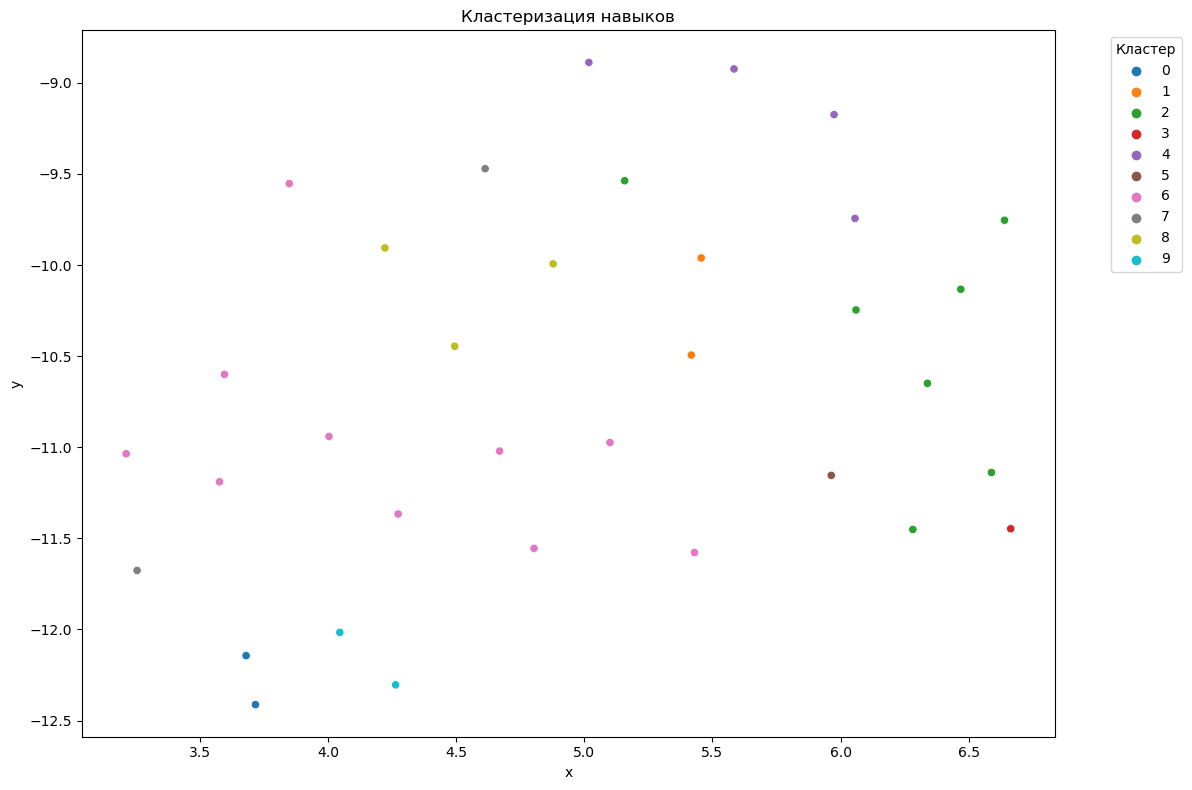

Извлечённые навыки из резюме: ['apache spark', 'английский: c1', 'clickhouse', 'публикации на kaggle', 'аналитик', 'вшэ', 'специализация: большие данные и машинное обучение', 'scipy)', 'машинное обучение: scikit-learn', 'иванов алексей петрович цель', '«специалист по большим данным»', 'ооо', 'участие в проектах по nlp', 'фио', 'clickhouse)', 'сертификаты:', 'специалист', '«системный аналитик»', 'python', 'data scientist / аналитик', 'nlp', 'numpy', '2022–2024):', 'jira', 'разработка моделей прогнозирования спроса', 'дополнительно:', 'образование:', 'программа: прикладная математика и информатика', 'tensorflow', 'управление проектами: agile', 'sql', 'знание профессиональных стандартов:', 'администрирование dwh', 'техносистемы', 'опыт :', '«специалист по data science» (ниу вшэ', '2024)', 'аналитик данных (ооо «техносистемы»', 'аккредитация: до 2028 г', 'seaborn', '«профессиональный стандарт 060402»', 'компьютерное зрение', 'tableau', 'визуализация: matplotlib', 'ниу вшэ / университет итм

In [37]:
def pipeline(resume_text: str, alliance_json_path: str):
    # 1. Загрузка данных компетенций
    df_competencies = load_skills_from_alliance(alliance_json_path)
    
    # 2. Векторизация компетенций
    embeddings = embed_skills(df_competencies['name'])
    
    # 3. Кластеризация
    labels, kmeans_model = cluster_skills(embeddings)
    df_competencies['cluster'] = labels
    df_competencies.to_csv('data/clustered_skills.csv', index=False, encoding='utf-8')
    
    # 4. Визуализация (опционально)
    visualize_clusters(embeddings, labels, df_competencies['name'])
    
    # 5. Извлечение навыков из резюме
    resume_skills = extract_resume_skills(resume_text)
    
    # 6. Нормализация навыков
    synonyms = {
        'python': ['python', 'python3', 'python 3.8'],
        'sql': ['sql', 'postgresql', 'mysql'],
        'docker': ['docker', 'docker-compose']
    }
    normalized_skills = normalize_skills(resume_skills, synonyms)
    
    # 7. Сопоставление с компетенциями
    job_requirements = df_competencies['name'].tolist()
    matched = match_skills(normalized_skills, job_requirements)
    
    # 8. Оценка важности (например, можно по частоте упоминаний в названиях компетенций)
    job_text = ' '.join(job_requirements)
    importance = assess_skill_importance(job_text, normalized_skills)
    
    # 9. Вывод результатов
    print("Извлечённые навыки из резюме:", normalized_skills)
    print("Совпадения навыков с компетенциями:")
    print(matched)
    print("Важность навыков:")
    print(importance)

# Запуск пайплайна:
if __name__ == "__main__":
    resume_text = open('data/sample_resume_ru.txt', encoding='utf-8').read()
    alliance_json_path = 'data/alliance_matrix.json'
    pipeline(resume_text, alliance_json_path)


In [ ]:
import os
import json
import re
import pandas as pd
import numpy as np
import spacy
from sentence_transformers import SentenceTransformer
from sentence_transformers.cross_encoder import CrossEncoder

os.makedirs('models', exist_ok=True)

# Загрузка spaCy модели (английский, если нужен русский — поменяй)
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'
CROSS_ENCODER_MODEL = 'cross-encoder/stsb-TinyBERT-L-4'

# Загрузка матрицы из JSON и вытягивание компетенций
def load_competencies(json_path: str):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    all_competencies = []
    for role_id, role_data in data["roles"].items():
        for comp in role_data["competencies"]:
            all_competencies.append({
                "role_id": role_id,
                "role_name": role_data["name"],
                "competency_name": comp["name"].lower(),
                "required_level_code": comp.get("required_level_code", 1),
                "required_level_name": comp.get("required_level_name", "Базовый")
            })
    return pd.DataFrame(all_competencies)

# Извлечение навыков из текста резюме (твой пример можно вставить сюда как строку)
def extract_resume_skills(text: str):
    doc = nlp(text)
    # Можно извлекать сущности по SKILL или просто все слова с длиной > 2 для примера
    skills = set()
    for token in doc:
        if not token.is_stop and not token.is_punct and len(token.text) > 2:
            skills.add(token.text.lower())
    return list(skills)

# Сравнение навыков кандидата с компетенциями через in (по вхождению строки)
def match_skills_with_competencies(candidate_skills, competencies_df):
    matched = []
    missing = []

    for _, comp in competencies_df.iterrows():
        comp_name = comp['competency_name']
        role_name = comp['role_name']
        level_code = comp['required_level_code']

        # Проверяем, есть ли хоть один навык кандидата внутри компетенции (или наоборот)
        if any(cs in comp_name or comp_name in cs for cs in candidate_skills):
            matched.append({
                "role": role_name,
                "competency": comp_name,
                "level_code": level_code,
                "level_name": comp['required_level_name']
            })
        else:
            missing.append({
                "role": role_name,
                "competency": comp_name,
                "level_code": level_code,
                "level_name": comp['required_level_name']
            })

    return matched, missing

# Преобразование уровня значимости по коду
def importance_level(code: int) -> str:
    return {1: "low", 2: "medium", 3: "high"}.get(code, "low")

def main():
    # Пример резюме (твой текст сюда вставь)
    resume_text = """
    ФИО: Иванов Алексей Петрович
    Цель: Трудоустройство на позицию Data Scientist / Аналитик данных с фокусом на машинное обучение и большие данные.
    Ключевые навыки:
    Анализ данных: Python (Pandas, NumPy, SciPy), SQL, Apache Spark.
    Машинное обучение: Scikit-learn, TensorFlow, NLP, компьютерное зрение.
    Визуализация: Matplotlib, Seaborn, Tableau.
    Управление проектами: Agile, Jira.
    """

    competencies_df = load_competencies('data/alliance_matrix.json')

    candidate_skills = extract_resume_skills(resume_text)
    print("Извлечённые навыки кандидата:\n", candidate_skills)

    matched, missing = match_skills_with_competencies(candidate_skills, competencies_df)

    print("\nСовпавшие компетенции:")
    for m in matched:
        print(f"- Роль: {m['role']}, Компетенция: {m['competency']}, Уровень: {importance_level(m['level_code'])}")

    print("\nОтсутствующие компетенции:")
    for mm in missing:
        print(f"- Роль: {mm['role']}, Компетенция: {mm['competency']}, Уровень: {importance_level(mm['level_code'])}")

if __name__ == '__main__':
    main()


In [38]:
# custom_skill_ner_model.py
# Модель NER для извлечения навыков из резюме без использования предобученных моделей BERT

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# -------------------------
# Подготовка данных
# -------------------------

def build_vocab(texts):
    word_to_ix = defaultdict(lambda: len(word_to_ix))
    word_to_ix["<PAD>"] = 0
    for text in texts:
        for word in text.lower().split():
            _ = word_to_ix[word]
    return word_to_ix

def annotate(text, competency_list):
    words = text.lower().split()
    labels = ["O"] * len(words)
    for skill in competency_list:
        skill_words = skill.lower().split()
        for i in range(len(words) - len(skill_words) + 1):
            if words[i:i+len(skill_words)] == skill_words:
                labels[i] = "B-COMP"
                for j in range(1, len(skill_words)):
                    labels[i + j] = "I-COMP"
    return words, labels

# -------------------------
# Dataset
# -------------------------

class ResumeSkillDataset(Dataset):
    def __init__(self, texts, competencies, word_to_ix, label_to_ix):
        self.data = []
        for text in texts:
            words, labels = annotate(text, competencies)
            word_ids = [word_to_ix.get(w, 0) for w in words]
            label_ids = [label_to_ix[l] for l in labels]
            self.data.append((word_ids, label_ids))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x), torch.tensor(y)

# -------------------------
# Модель
# -------------------------

class SkillTagger(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SkillTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        emb = self.embedding(x)
        lstm_out, _ = self.lstm(emb)
        out = self.fc(lstm_out)
        return out

# -------------------------
# Обучение
# -------------------------

def train_model(model, dataloader, label_pad_id=0, epochs=10):
    criterion = nn.CrossEntropyLoss(ignore_index=label_pad_id)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in dataloader:
            output = model(x_batch)
            loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# -------------------------
# Пример использования
# -------------------------

if __name__ == "__main__":
    texts = [
        "Занимался разработкой моделей машинного обучения и использовал Docker",
        "Изучал тренды искусственного интеллекта и работал с Git"
    ]

    competencies = [
        "модели машинного обучения",
        "Docker",
        "искусственный интеллект",
        "Git"
    ]

    label_to_ix = {"O": 0, "B-COMP": 1, "I-COMP": 2}
    word_to_ix = build_vocab(texts)

    dataset = ResumeSkillDataset(texts, competencies, word_to_ix, label_to_ix)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

    model = SkillTagger(vocab_size=len(word_to_ix), embedding_dim=64, hidden_dim=128, output_dim=len(label_to_ix))
    train_model(model, dataloader)

    # Для тестов: model(torch.tensor([[1, 2, 3, 4]]))

Epoch 1: Loss = 1.1583
Epoch 2: Loss = 0.5816
Epoch 3: Loss = 0.2329
Epoch 4: Loss = 0.0661
Epoch 5: Loss = 0.0158
Epoch 6: Loss = 0.0040
Epoch 7: Loss = 0.0012
Epoch 8: Loss = 0.0004
Epoch 9: Loss = 0.0002
Epoch 10: Loss = 0.0001


In [39]:
# custom_skill_ner_model.py
# Модель NER для извлечения навыков из резюме без использования предобученных моделей BERT

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import numpy as np

# -------------------------
# Подготовка данных
# -------------------------

def build_vocab(texts):
    word_to_ix = defaultdict(lambda: len(word_to_ix))
    word_to_ix["<PAD>"] = 0
    for text in texts:
        for word in text.lower().split():
            _ = word_to_ix[word]
    return word_to_ix

def annotate(text, competency_list):
    words = text.lower().split()
    labels = ["O"] * len(words)
    for skill in competency_list:
        skill_words = skill.lower().split()
        for i in range(len(words) - len(skill_words) + 1):
            if words[i:i+len(skill_words)] == skill_words:
                labels[i] = "B-COMP"
                for j in range(1, len(skill_words)):
                    labels[i + j] = "I-COMP"
    return words, labels

# -------------------------
# Dataset
# -------------------------

class ResumeSkillDataset(Dataset):
    def __init__(self, texts, competencies, word_to_ix, label_to_ix):
        self.data = []
        for text in texts:
            words, labels = annotate(text, competencies)
            word_ids = [word_to_ix.get(w, 0) for w in words]
            label_ids = [label_to_ix[l] for l in labels]
            self.data.append((word_ids, label_ids))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x), torch.tensor(y)

# -------------------------
# Модель
# -------------------------

class SkillTagger(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SkillTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        emb = self.embedding(x)
        lstm_out, _ = self.lstm(emb)
        out = self.fc(lstm_out)
        return out

# -------------------------
# Обучение
# -------------------------

def train_model(model, dataloader, label_pad_id=0, epochs=10):
    criterion = nn.CrossEntropyLoss(ignore_index=label_pad_id)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in dataloader:
            output = model(x_batch)
            loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# -------------------------
# Сравнение с обучающим списком компетенций
# -------------------------

def compare_resume_with_competencies(resume_text, competency_objects):
    found = []
    missing = []
    resume_text_lower = resume_text.lower()

    for comp in competency_objects:
        skill = comp["name"].lower()
        if skill in resume_text_lower:
            found.append({
                "name": comp["name"],
                "level": comp["required_level_name"],
                "status": "найдено"
            })
        else:
            missing.append({
                "name": comp["name"],
                "level": comp["required_level_name"],
                "status": "нужно доучить"
            })

    return found, missing

# -------------------------
# Пример использования
# -------------------------

if __name__ == "__main__":
    texts = [
        "Занимался разработкой моделей машинного обучения и использовал Docker",
        "Изучал тренды искусственного интеллекта и работал с Git"
    ]

    competencies = [
        "модели машинного обучения",
        "Docker",
        "искусственный интеллект",
        "Git"
    ]

    competency_objects = [
        {"name": "модели машинного обучения", "required_level_name": "Продвинутый"},
        {"name": "Docker", "required_level_name": "Базовый"},
        {"name": "искусственный интеллект", "required_level_name": "Базовый"},
        {"name": "Git", "required_level_name": "Базовый"},
        {"name": "Bash", "required_level_name": "Продвинутый"}
    ]

    label_to_ix = {"O": 0, "B-COMP": 1, "I-COMP": 2}
    word_to_ix = build_vocab(texts)

    dataset = ResumeSkillDataset(texts, competencies, word_to_ix, label_to_ix)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

    model = SkillTagger(vocab_size=len(word_to_ix), embedding_dim=64, hidden_dim=128, output_dim=len(label_to_ix))
    train_model(model, dataloader)

    # Сравнение
    test_resume = "Работал с Docker и Git, занимался ML"
    found, missing = compare_resume_with_competencies(test_resume, competency_objects)
    print("\nНайдено в резюме:")
    for f in found:
        print(f" - {f['name']} (уровень: {f['level']})")

    print("\nНужно доучить:")
    for m in missing:
        print(f" - {m['name']} (требуемый уровень: {m['level']})")

Epoch 1: Loss = 1.0914
Epoch 2: Loss = 0.5748
Epoch 3: Loss = 0.2358
Epoch 4: Loss = 0.0659
Epoch 5: Loss = 0.0151
Epoch 6: Loss = 0.0036
Epoch 7: Loss = 0.0010
Epoch 8: Loss = 0.0003
Epoch 9: Loss = 0.0001
Epoch 10: Loss = 0.0001

Найдено в резюме:
 - Docker (уровень: Базовый)
 - Git (уровень: Базовый)

Нужно доучить:
 - модели машинного обучения (требуемый уровень: Продвинутый)
 - искусственный интеллект (требуемый уровень: Базовый)
 - Bash (требуемый уровень: Продвинутый)


In [41]:
# custom_skill_ner_model.py
# Модель NER для извлечения навыков из резюме без использования предобученных моделей BERT

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import numpy as np
import os
import json

# -------------------------
# Подготовка данных
# -------------------------

def build_vocab(texts):
    word_to_ix = defaultdict(lambda: len(word_to_ix))
    word_to_ix["<PAD>"] = 0
    for text in texts:
        for word in text.lower().split():
            _ = word_to_ix[word]
    return word_to_ix

def annotate(text, competency_list):
    words = text.lower().split()
    labels = ["O"] * len(words)
    for skill in competency_list:
        skill_words = skill.lower().split()
        for i in range(len(words) - len(skill_words) + 1):
            if words[i:i+len(skill_words)] == skill_words:
                labels[i] = "B-COMP"
                for j in range(1, len(skill_words)):
                    labels[i + j] = "I-COMP"
    return words, labels

# -------------------------
# Dataset
# -------------------------

class ResumeSkillDataset(Dataset):
    def __init__(self, texts, competencies, word_to_ix, label_to_ix):
        self.data = []
        for text in texts:
            words, labels = annotate(text, competencies)
            word_ids = [word_to_ix.get(w, 0) for w in words]
            label_ids = [label_to_ix[l] for l in labels]
            self.data.append((word_ids, label_ids))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x), torch.tensor(y)

# -------------------------
# Модель
# -------------------------

class SkillTagger(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SkillTagger, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        emb = self.embedding(x)
        lstm_out, _ = self.lstm(emb)
        out = self.fc(lstm_out)
        return out

# -------------------------
# Обучение
# -------------------------

def train_model(model, dataloader, label_pad_id=0, epochs=10):
    criterion = nn.CrossEntropyLoss(ignore_index=label_pad_id)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in dataloader:
            output = model(x_batch)
            loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

# -------------------------
# Сравнение с обучающим списком компетенций
# -------------------------

def compare_resume_with_competencies(resume_text, competency_objects):
    found = []
    missing = []
    resume_text_lower = resume_text.lower()

    for comp in competency_objects:
        skill = comp["name"].lower()
        if skill in resume_text_lower:
            found.append({
                "name": comp["name"],
                "level": comp["required_level_name"],
                "status": "найдено"
            })
        else:
            missing.append({
                "name": comp["name"],
                "level": comp["required_level_name"],
                "status": "нужно доучить"
            })

    return found, missing

# -------------------------
# Чтение компетенций из JSON
# -------------------------

def load_competencies_from_alliance_matrix(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    competencies = []
    for role_code, role_data in data.get("roles", {}).items():
        competencies.extend(role_data.get("competencies", []))
    return competencies

# -------------------------
# Пример использования
# -------------------------

if __name__ == "__main__":
    texts = [
        "Занимался разработкой моделей машинного обучения и использовал Docker",
        "Изучал тренды искусственного интеллекта и работал с Git"
    ]

    # Загрузка компетенций из JSON
    alliance_path = "alliance_matrix.json"
    if os.path.exists(alliance_path):
        competency_objects = load_competencies_from_alliance_matrix(alliance_path)
        competencies = [c["name"] for c in competency_objects]
    else:
        competency_objects = [
            {"name": "модели машинного обучения", "required_level_name": "Продвинутый"},
            {"name": "Docker", "required_level_name": "Базовый"},
            {"name": "искусственный интеллект", "required_level_name": "Базовый"},
            {"name": "Git", "required_level_name": "Базовый"},
            {"name": "Bash", "required_level_name": "Продвинутый"}
        ]
        competencies = [c["name"] for c in competency_objects]

    label_to_ix = {"O": 0, "B-COMP": 1, "I-COMP": 2}
    word_to_ix = build_vocab(texts)

    dataset = ResumeSkillDataset(texts, competencies, word_to_ix, label_to_ix)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

    model = SkillTagger(vocab_size=len(word_to_ix), embedding_dim=64, hidden_dim=128, output_dim=len(label_to_ix))
    train_model(model, dataloader)

    # Чтение резюме из файла
    resume_path = "sample_resume.txt"
    if os.path.exists(resume_path):
        with open(resume_path, "r", encoding="utf-8") as f:
            test_resume = f.read()
    else:
        test_resume = "Работал с Docker и Git, занимался ML"

    found, missing = compare_resume_with_competencies(test_resume, competency_objects)
    print("\nНайдено в резюме:")
    for f in found:
        print(f" - {f['name']} (уровень: {f['level']})")

    print("\nНужно доучить:")
    for m in missing:
        print(f" - {m['name']} (требуемый уровень: {m['level']})")

Epoch 1: Loss = 1.0552
Epoch 2: Loss = 0.5071
Epoch 3: Loss = 0.1691
Epoch 4: Loss = 0.0379
Epoch 5: Loss = 0.0075
Epoch 6: Loss = 0.0017
Epoch 7: Loss = 0.0005
Epoch 8: Loss = 0.0002
Epoch 9: Loss = 0.0001
Epoch 10: Loss = 0.0000

Найдено в резюме:
 - Docker (уровень: Базовый)
 - Git (уровень: Базовый)

Нужно доучить:
 - модели машинного обучения (требуемый уровень: Продвинутый)
 - искусственный интеллект (требуемый уровень: Базовый)
 - Bash (требуемый уровень: Продвинутый)
